In [38]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import tree
from matplotlib import pyplot as plt
from scipy.stats import norm
import scipy.special
import seaborn as sns

In [292]:
"""
b:= number of paths
m:= length of path
max_depth:= max depth of trees
S_0:= initial stock price
K:= strike price
T:= time to maturity in years
freq:= depth of binomial tree per Bermudan period
gbm_freq:= number of discrete steps in calculating stock price per Bermudan period
"""
b = 10000
m = 10
maxdepth = 5
S_0 = 10
mu = 0.01
sigma = .3
option_type = "put"
T = 1
K = 12
freq = 500
gbm_freq = 1

In [277]:
def gbm(S_0, mu, sigma, steps, b,T):
    result = np.full((steps+1, b), S_0, dtype = 'float64')
    rands = np.random.normal(scale = np.sqrt(T/steps),size=(steps, b))
    cum_rands = np.zeros((steps+1, b))
    endpoints = np.zeros((b))
    for i in range(1,steps+1):
        #if (100*i)%steps == 0:
            #print(100*i//steps,"out of 100")
        cum_rands[i,:] = cum_rands[i-1,:] + rands[i-1,:]
        for j in range(b):
            result[i,j] = S_0*np.exp((mu-(sigma**2)/2)*(T/steps)*i + sigma*(cum_rands[i,j]))
            
    return result

In [278]:
def option_value(t,S,option_type,K,r,T,m):
    if option_type == "call":
        return np.where(S > K, (S-K)*np.exp(r*T*(-t/m)), 0)
    elif option_type == "put":
        return np.where(S > K, 0, (K-S)*np.exp(r*T*(-t/m)))

In [279]:
def blackscholes_pred(option_type, S_0, K, T, mu, sigma):
    #bermudan_factor = np.exp(0.5*(np.exp(mu*T*(1-1/m))-1)*(1-mu)*T)
    #print("bermudan factor:", bermudan_factor)
    d1 = (np.log(S_0/K) + (mu + (sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == "call":
        result = S_0*norm.cdf(d1) - K*np.exp(-mu*T)*norm.cdf(d2)
        result = result
    elif option_type == "put":
        result = K*np.exp(-mu*T)*norm.cdf(-d2) - S_0*norm.cdf(-d1) 
        #print('result')
        result = result
    return result
    #return result, result*bermudan_factor

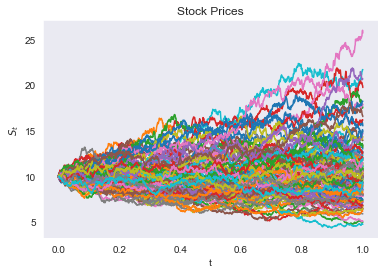

In [286]:
X_plot = gbm(S_0, mu, sigma, m*gbm_freq, b,T)
t = np.linspace(0, T, m*gbm_freq+1)
plt.title("Stock Prices")
plt.xlabel("t")
plt.ylabel("$S_{t}$")
plt.plot(t,X_plot);

In [310]:
def binomialtree(freq,sigma,m,S_0,option_type,K,mu,T):
    exercise_histogram = np.zeros((m+1))
    exercise_count = 0
    #freq is steps per period
    u = np.exp(np.sqrt(T/(freq*m))*sigma)
    #print("potential overflow in binomial tree:", u**(100*100))
    d = 1/u
    p = (np.exp(mu*T/(freq*m))-d)/(u-d)
    if p < 0 or p > 1:
        raise Exception("Invalid probability for binomial tree")
    tree = np.zeros((m*freq+1,m*freq+1))
    for j in range(m*freq+1):
        #print("potential overflow:",u**j)
        S = S_0*(u**(2*j-m*freq))
        #print("Stock price at last branch in binomial tree: ",S)
        tree[m*freq,j] = option_value(m,S,option_type,K,mu,T,m)
    #print(tree[-1])
    for i in range(m*freq-1,-1,-1):
        for j in range(i+1):
            if (i%freq) != 0:
                tree[i,j] = p*tree[i+1,j+1]+(1-p)*(tree[i+1,j])
            else:
                S = S_0*(u**(2*j-i))
                exerciseval = option_value(i//freq,S,option_type,K,mu,T,m)
                if exerciseval > p*tree[i+1,j+1]+(1-p)*(tree[i+1,j]):
                    tree[i,j] = exerciseval
                    exercise_histogram[i//freq] += 2**(m-i)
                    exercise_count += 2**(m-i)
                else:
                    tree[i,j] = p*tree[i+1,j+1]+(1-p)*(tree[i+1,j])
    #print(tree)
    exercise_histogram[-1] = 2**m-exercise_count
    return tree[0,0],exercise_histogram

In [51]:
def euro_binomialtree(freq,sigma,m,S_0,option_type,K,r,T):
    #freq is steps per period
    u = np.exp(np.sqrt(T/(freq*m))*sigma)
    #print("potential overflow in binomial tree:", u**(100*100))
    d = 1/u
    p = (np.exp(mu*T/(freq*m))-d)/(u-d)
    if p < 0 or p > 1:
        raise Exception("Invalid probability for binomial tree")
    tree = np.zeros((m*freq+1,m*freq+1))
    for j in range(m*freq+1):
        #print("potential overflow:",u**j)
        S = S_0*(u**(2*j-m*freq))
        #print("Stock price at last branch in binomial tree: ",S)
        tree[m*freq,j] = option_value(m,S,option_type,K,r,T,m)
    #print("here", tree[-1])
    for i in range(m*freq-1,-1,-1):
        for j in range(i+1):
            if True:
                tree[i,j] = p*tree[i+1,j+1]+(1-p)*(tree[i+1,j])
    #print(tree)
    return tree[0,0],tree

In [307]:
def LSregression_tree(X,freq,sigma,m,b,S_0,option_type,K,mu,T,gbm_freq,depth):
    #base case
    V_hat = np.zeros((m+1,b))
    V_hat[m,:] = option_value(m,X[-1,:],option_type,K,mu,T,m)
    exercise_histogram = np.zeros((m+1))
    exercise_count = 0
    alreadyexercised = np.zeros((b))

    #inductive step
    for t in range(m-1,-1,-1):
        current_tree = DecisionTreeRegressor(max_depth = depth)
        current_tree.fit(X[t*gbm_freq].reshape(-1,1),V_hat[t+1])
        exercisevals = option_value(t,X[t*gbm_freq],option_type,K,mu,T,m)
        tree_preds = current_tree.predict(X[t*gbm_freq].reshape(-1,1))
        for j in range(b):
            if exercisevals[j] > tree_preds[j]:
                V_hat[t,j] = exercisevals[j]
                if alreadyexercised[j] == 0:
                    exercise_count += 1
                    exercise_histogram[t] += 1
                    alreadyexercised[j] = 1
            else:
                V_hat[t,j] = tree_preds[j]
    exercise_histogram[-1] = b-exercise_count
    return V_hat[0][0],exercise_histogram

In [296]:
X = gbm(S_0, mu, sigma, m*1, b,T)

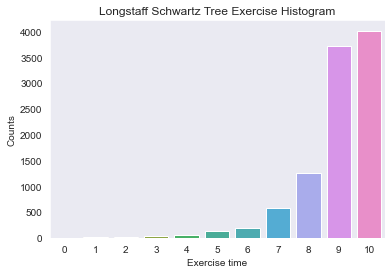

In [309]:
#EXERCISE TIME HISTOGRAM LS REGRESSION TREE
reg_tree_histogram = LSregression_tree(X,freq,sigma,m,b,S_0,option_type,K,mu,T,gbm_freq,maxdepth)[1]
ax=sns.barplot(x=np.arange(m+1),y=reg_tree_histogram,ci=None)
ax.set(xlabel='Exercise time', ylabel='Counts', title='Longstaff Schwartz Tree Exercise Histogram')
plt.show()

In [146]:
#TEST LS REGRESSION TREE FOR DIFFERENT DEPTH VALUES
#GENERATE PRICES
T_vals = [1]
mu_vals = [.01,.03,.05]
sigma_vals = [.1,.3,.5]
depth_vals = [1,2,3,4,5,6,7,8,9,10]
prices = np.zeros((len(depth_vals)+1,len(mu_vals)*len(sigma_vals)*len(T_vals)*3))
col_labels = [""]*len(mu_vals)*len(sigma_vals)*len(T_vals)*3
col = 0
for mu in mu_vals:
    mu_string = "\u03BC="+str(np.round(mu,2))+"\n"
    for sigma in sigma_vals:
        sigma_string = "\u03C3="+str(np.round(sigma,2))+"\n"
        for T in T_vals:
            X=gbm(S_0, mu, sigma, m*gbm_freq, b,T)
            K_vals = [S_0*np.exp(T*mu)*(1-np.sqrt(np.exp((sigma**2)*T)-1)),S_0*np.exp(T*mu),S_0*np.exp(T*mu)*(1+np.sqrt(np.exp((sigma**2)*T)-1))]
            for i in range(len(K_vals)):
                K_string = "K="+str(np.round(K_vals[i],2))
                col_labels[col] = mu_string+sigma_string+K_string
                prices[0,col] = binomialtree(freq,sigma,1,S_0,option_type,K_vals[i],mu,T)
                row = 1
                for depth in depth_vals:
                    prices[row,col] = LSregression_tree(X,freq,sigma,m,b,S_0,option_type,K_vals[i],mu,T,gbm_freq,depth)
                    row += 1
                col += 1

In [ ]:
#COLOR CODE TABLE
tree_performance = np.abs(prices-prices[0])
argmin = np.argmin(tree_performance[1:,:], axis=0)
grid = np.indices(np.shape(tree_performance))
colors = np.where(grid[0] == argmin+1,'r','w')
colors = np.where(grid[0]==np.zeros(np.shape(tree_performance)[1]),'lightgray',colors)

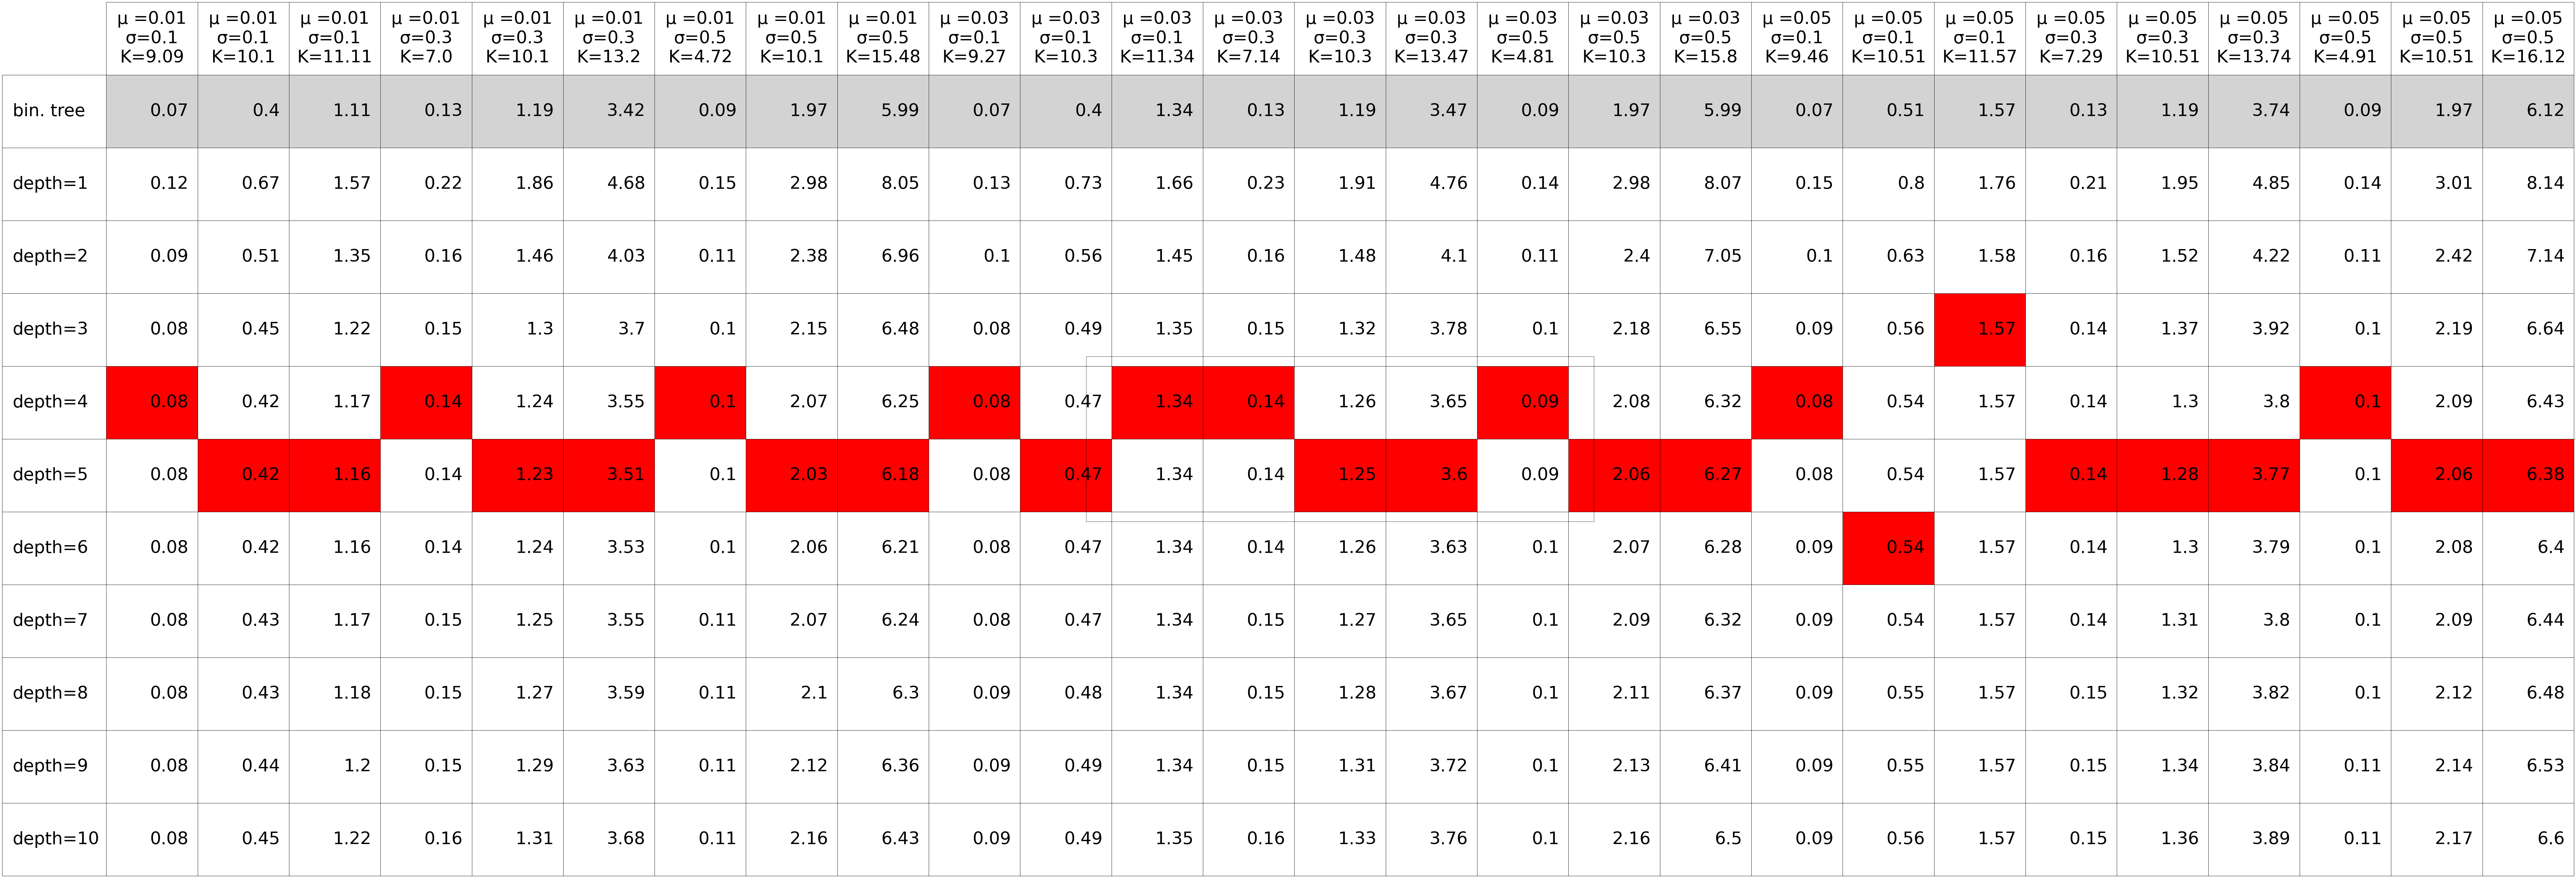

In [213]:
#PRINT TABLE
#row_labels = str(depth_vals)
idx = Index(["bin. tree"]+depth_vals)
#df = DataFrame(randn(len(depth_vals), 27), index=idx, columns=np.arange(27))
#vals = np.around(df.values,2)
#norm = plt.Normalize(vals.min()-1, vals.max()+1)
#colours = plt.cm.hot(normal(vals))
vals = np.around(prices,2)
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
#col_labels = np.arange(54)
the_table=plt.table(cellText=vals, rowLabels=row_labels, colLabels=col_labels, 
                    colWidths = [0.03]*vals.shape[1], loc='center',cellColours=colors)
the_table.scale(6, 20)
the_table.set_fontsize(150)
plt.show()

In [ ]:
#GENERATE THE DATA VIA BINOMIAL TREE AND LS REGRESSION TREE
mu = 0.01
sigma = 0.3
T = 1
S_0 = 10
option_type = 'put'
steps = 3960
b=10000
freq=500
K_vals = [S_0*np.exp(T*mu)*(1-np.sqrt(np.exp((sigma**2)*T)-1)),S_0*np.exp(T*mu),S_0*np.exp(T*mu)*(1+np.sqrt(np.exp((sigma**2)*T)-1))]
m_vals = [1,2,3,4,5,6,8,9,10,11,12]
depths = [4,5,5]
#X = gbm(S_0, mu, sigma, steps, b,T)
data_bintree = [{},{},{}]
data_regtree = [{},{},{}]
for i in range(3):
    K = K_vals[i]
    for m in m_vals:
        print('K,m=',K,',',m)
        gbm_freq = int(np.rint(steps/m))
        data_bintree[i][m] = binomialtree(freq,sigma,m,S_0,option_type,K,mu,T)
        data_regtree[i][m] = LSregression_tree(X,1,sigma,m,b,S_0,option_type,K,mu,T,gbm_freq,depths[i])
        np.save('options_data_bintree', data_bintree)
        np.save('options_data_regtree', data_regtree)

<function matplotlib.pyplot.show(close=None, block=None)>

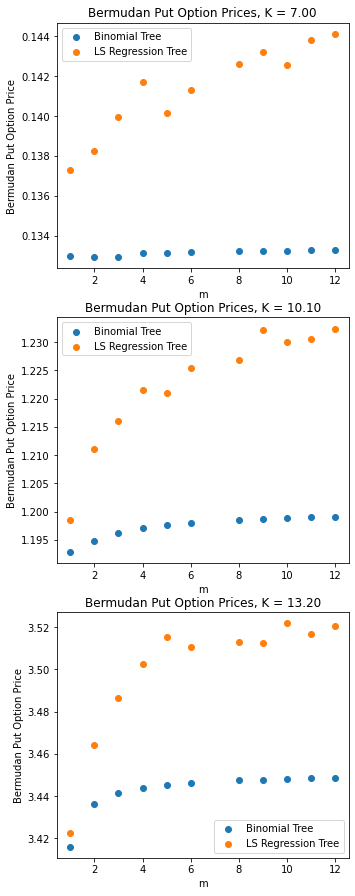

In [212]:
#GENERATE PLOTS
keys_binomial_Ksmall, values_binomial_Ksmall = zip(*data_bintree[0].items())
keys_regression_Ksmall, values_regression_Ksmall = zip(*data_regtree[0].items())
keys_binomial_Kmed, values_binomial_Kmed = zip(*data_bintree[1].items())
keys_regression_Kmed, values_regression_Kmed = zip(*data_regtree[1].items())
keys_binomial_Klarge, values_binomial_Klarge = zip(*data_bintree[2].items())
keys_regression_Klarge, values_regression_Klarge = zip(*data_regtree[2].items())

fig, ax = plt.subplots(3)

ax[0].scatter(keys_binomial_Ksmall, values_binomial_Ksmall)
ax[0].scatter(keys_regression_Ksmall, values_regression_Ksmall)
ax[0].set_title("Bermudan Put Option Prices, K = 7.00")
ax[0].legend(['Binomial Tree', 'LS Regression Tree'])

ax[1].scatter(keys_binomial_Kmed, values_binomial_Kmed)
ax[1].scatter(keys_regression_Kmed, values_regression_Kmed)
ax[1].set_title("Bermudan Put Option Prices, K = 10.10")
ax[1].legend(['Binomial Tree', 'LS Regression Tree'])

ax[2].scatter(keys_binomial_Klarge, values_binomial_Klarge)
ax[2].scatter(keys_regression_Klarge, values_regression_Klarge)
ax[2].set_title("Bermudan Put Option Prices, K = 13.20")
ax[2].legend(['Binomial Tree', 'LS Regression Tree'])

for ax in ax.flat:
    ax.set(xlabel='m', ylabel='Bermudan Put Option Price')
    
plt.subplots_adjust(bottom=0.1, right=0.8, top=3)


plt.show

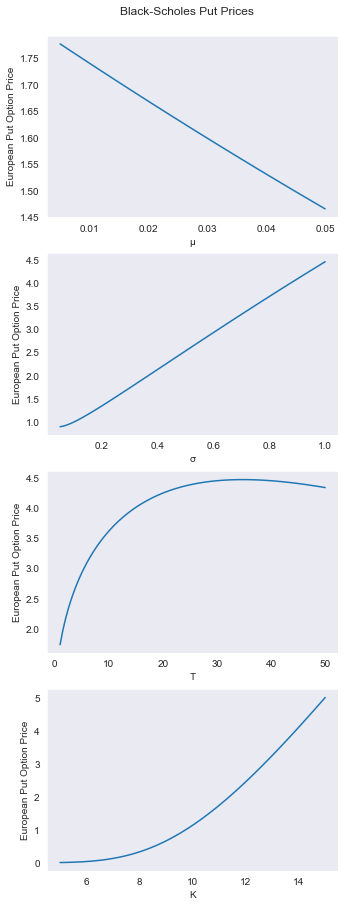

In [272]:
#PLOT EUROPEAN PRICES WITH BLACK-SCHOLES
option_type = 'put'
freq = 300
S_0 = 10
param_names = {0:'mu',1:'sigma',2:'T',3:'m',4:'K'}
param_ids = {v: k for k, v in param_names.items()}
default_and_ranges = {'mu':(0.01,0.005,0.05), 'sigma':(0.3,0.05,1), 'T':(1,1,50), 'm':(1,1,50), 'K':(11,5,15)}
params = [vals_and_ranges['mu'][0],vals_and_ranges['sigma'][0],vals_and_ranges['T'][0],vals_and_ranges['m'][0],vals_and_ranges['K'][0]]


mu = np.linspace(default_and_ranges['mu'][1], default_and_ranges['mu'][2],100)
sigma = np.linspace(default_and_ranges['sigma'][1], default_and_ranges['sigma'][2],100)
T = np.linspace(default_and_ranges['T'][1], default_and_ranges['T'][2],100)
K = np.linspace(default_and_ranges['K'][1], default_and_ranges['K'][2],100)

price_mu = blackscholes_pred(option_type, S_0, default_and_ranges['K'][0], default_and_ranges['T'][0], mu, default_and_ranges['sigma'][0])
price_sigma = blackscholes_pred(option_type, S_0, default_and_ranges['K'][0], default_and_ranges['T'][0], default_and_ranges['mu'][0], sigma)
price_T = blackscholes_pred(option_type, S_0, default_and_ranges['K'][0], T, default_and_ranges['mu'][0], default_and_ranges['sigma'][0])
price_K = blackscholes_pred(option_type, S_0, K, default_and_ranges['T'][0], default_and_ranges['mu'][0], default_and_ranges['sigma'][0])


# draw the graph

fig, ax = plt.subplots(4)
ax[0].plot(mu, price_mu)
ax[1].plot(sigma,price_sigma)
ax[2].plot(T, price_T)
ax[3].plot(K,price_K)

ax[0].set(xlabel='\u03BC', ylabel='European Put Option Price')
ax[1].set(xlabel='\u03C3', ylabel='European Put Option Price')
ax[2].set(xlabel='T', ylabel='European Put Option Price')
ax[3].set(xlabel='K', ylabel='European Put Option Price')    

plt.subplots_adjust(bottom=0.1, right=0.8, top=3)
plt.suptitle('Black-Scholes Put Prices', y=3.1, x= 0.45)
plt.show()
